In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [13]:
from mejiro.lenses import lens_util
detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

  0%|          | 0/975 [00:00<?, ?it/s]

100%|██████████| 975/975 [00:10<00:00, 91.02it/s] 


Number of detectable lenses: 975


In [14]:
# detectable_lenses = [l for l in detectable_lenses if l.snr > 25]
# print(f'Number of lenses amenable to substructure characterization: {len(detectable_lenses)}')

In [15]:
band = 'F129'
num_pix = 51
side = 5.61

array_list = []

for lens in tqdm(detectable_lenses):
    array = lens.get_array(num_pix=num_pix, side=side, band=band)
    array_list.append(array)

  0%|          | 0/975 [00:00<?, ?it/s]

100%|██████████| 975/975 [01:06<00:00, 14.70it/s]


In [16]:
snrs = [l.snr for l in detectable_lenses]

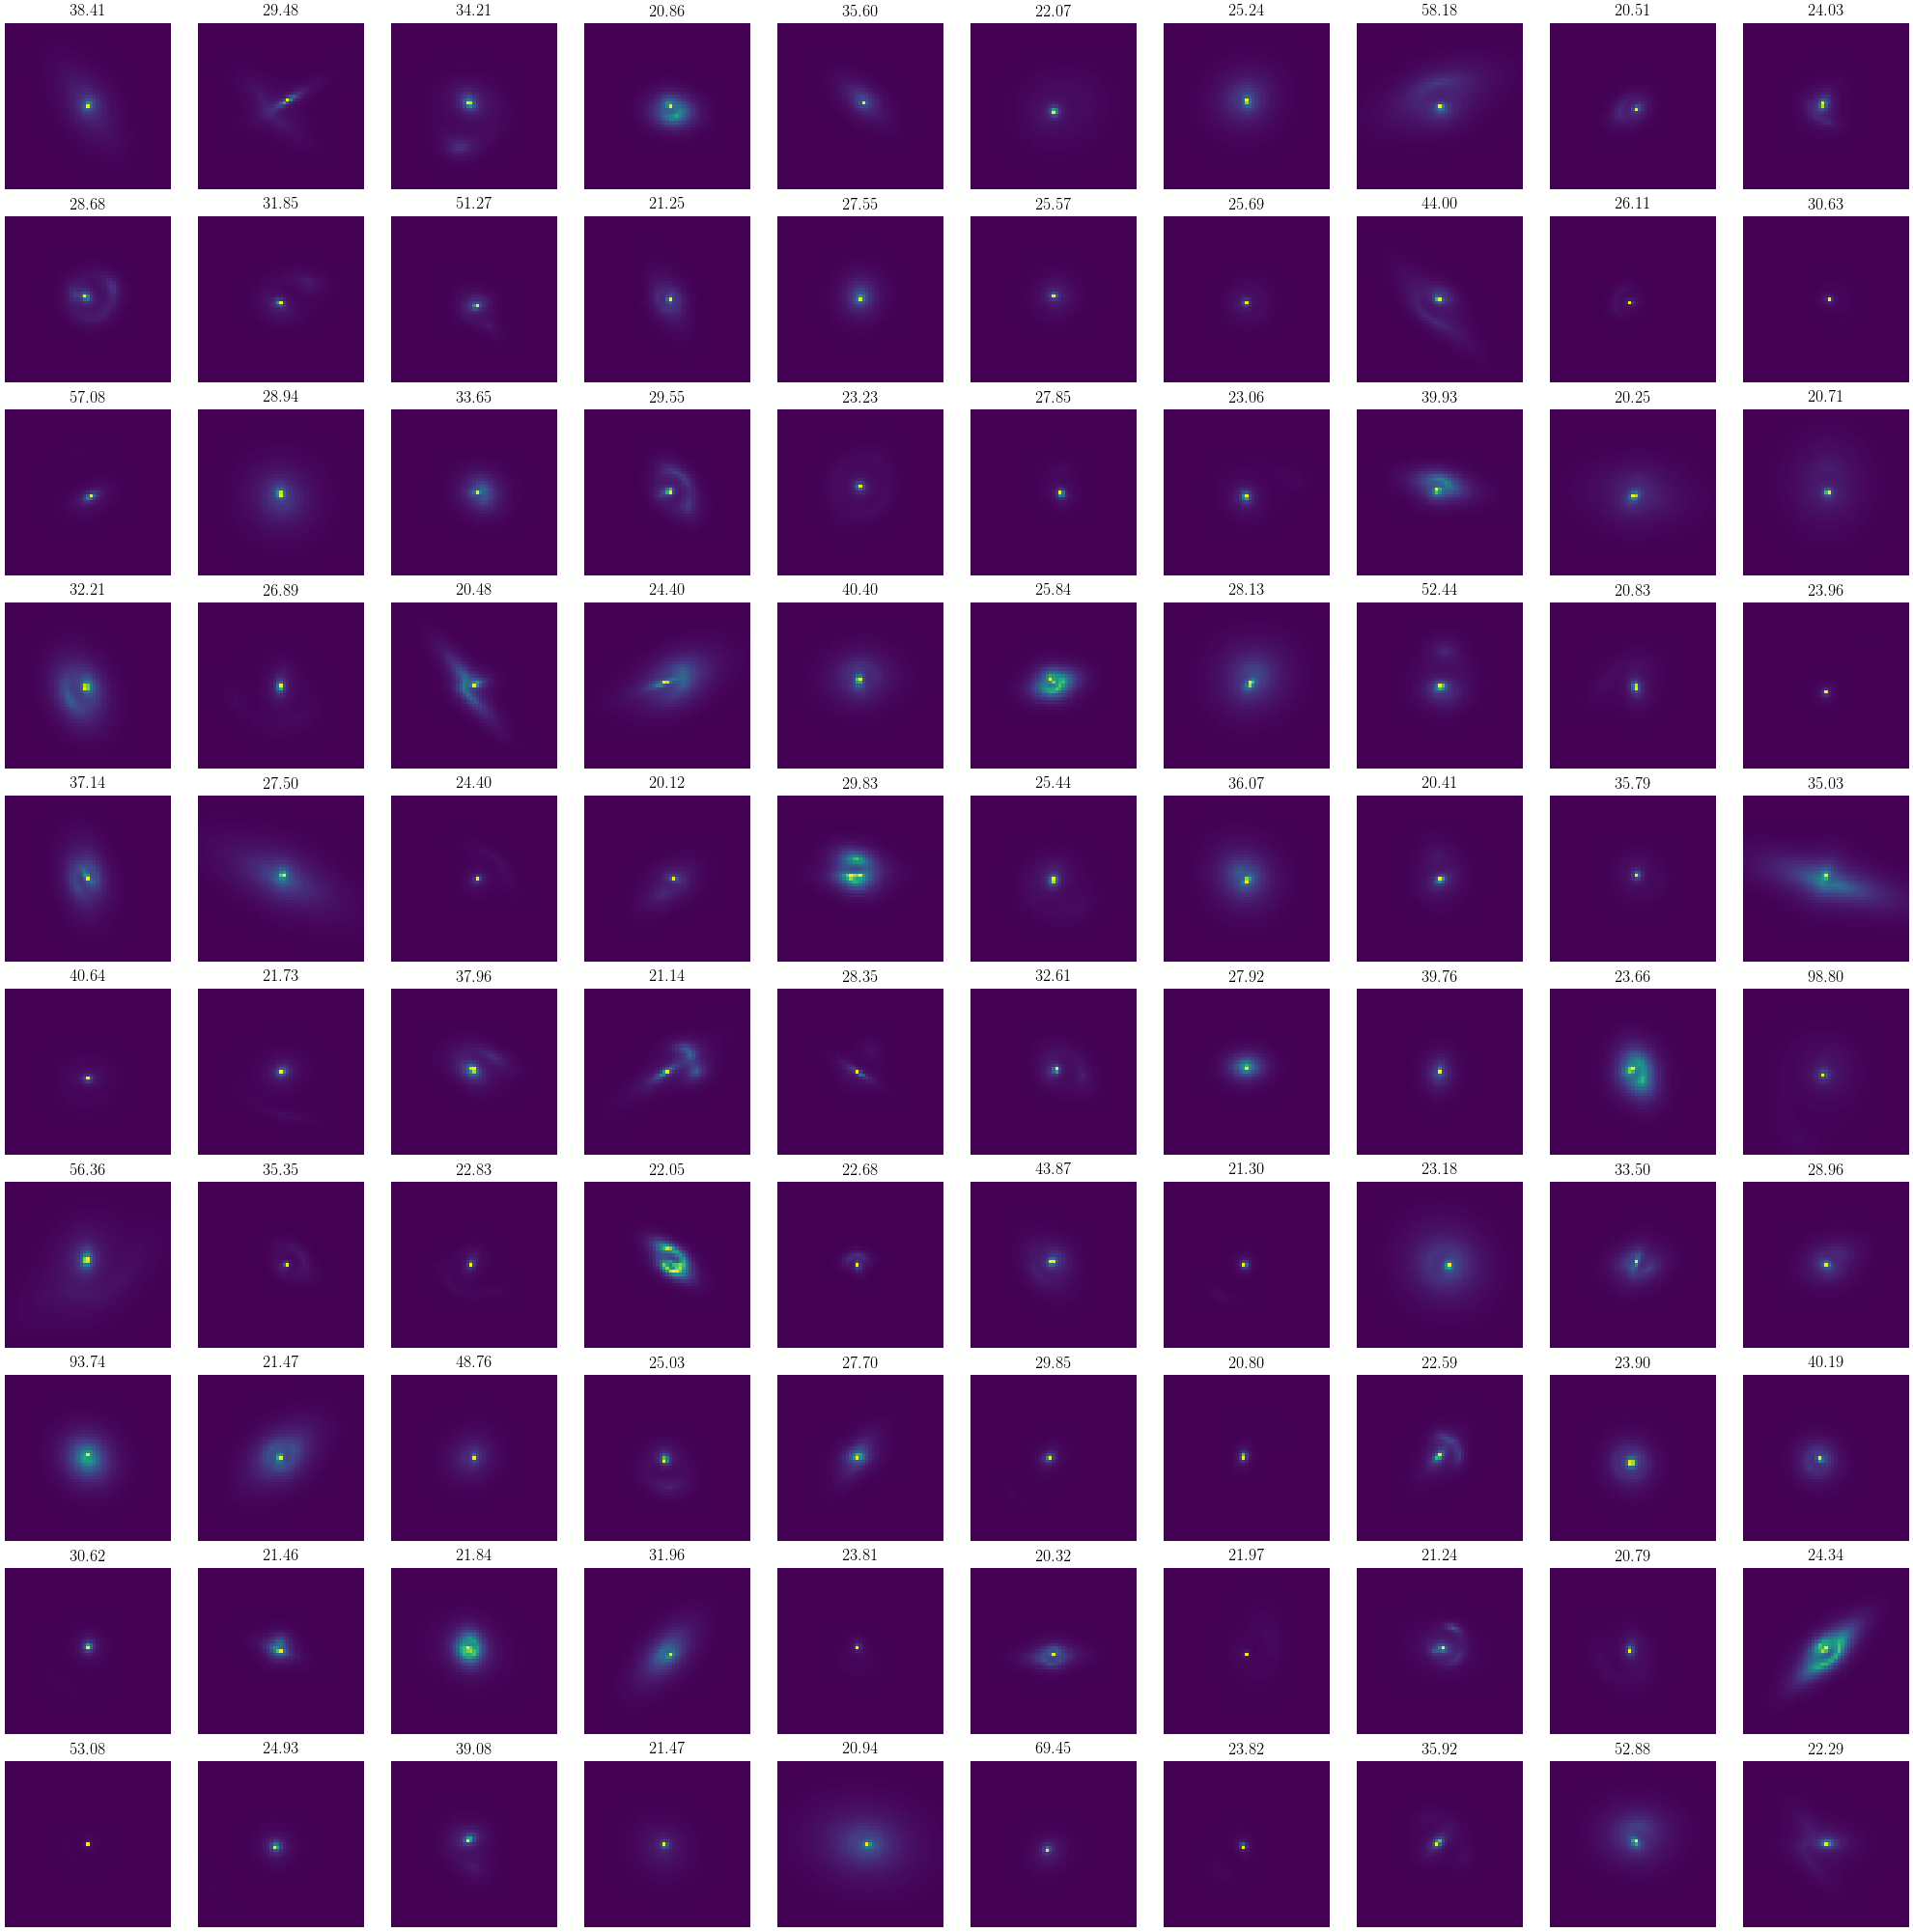

In [19]:
f, ax = plt.subplots(10, 10, figsize=(20, 20), constrained_layout=True)

i = 0
for x in range(10):
    for y in range(10):
        ax[x][y].imshow(array_list[i])
        ax[x][y].set_axis_off()
        ax[x][y].set_title(f'{snrs[i]:.2f}')
        i += 1

plt.savefig(os.path.join(figure_dir, 'snr_sanity_check.png'))
plt.show()

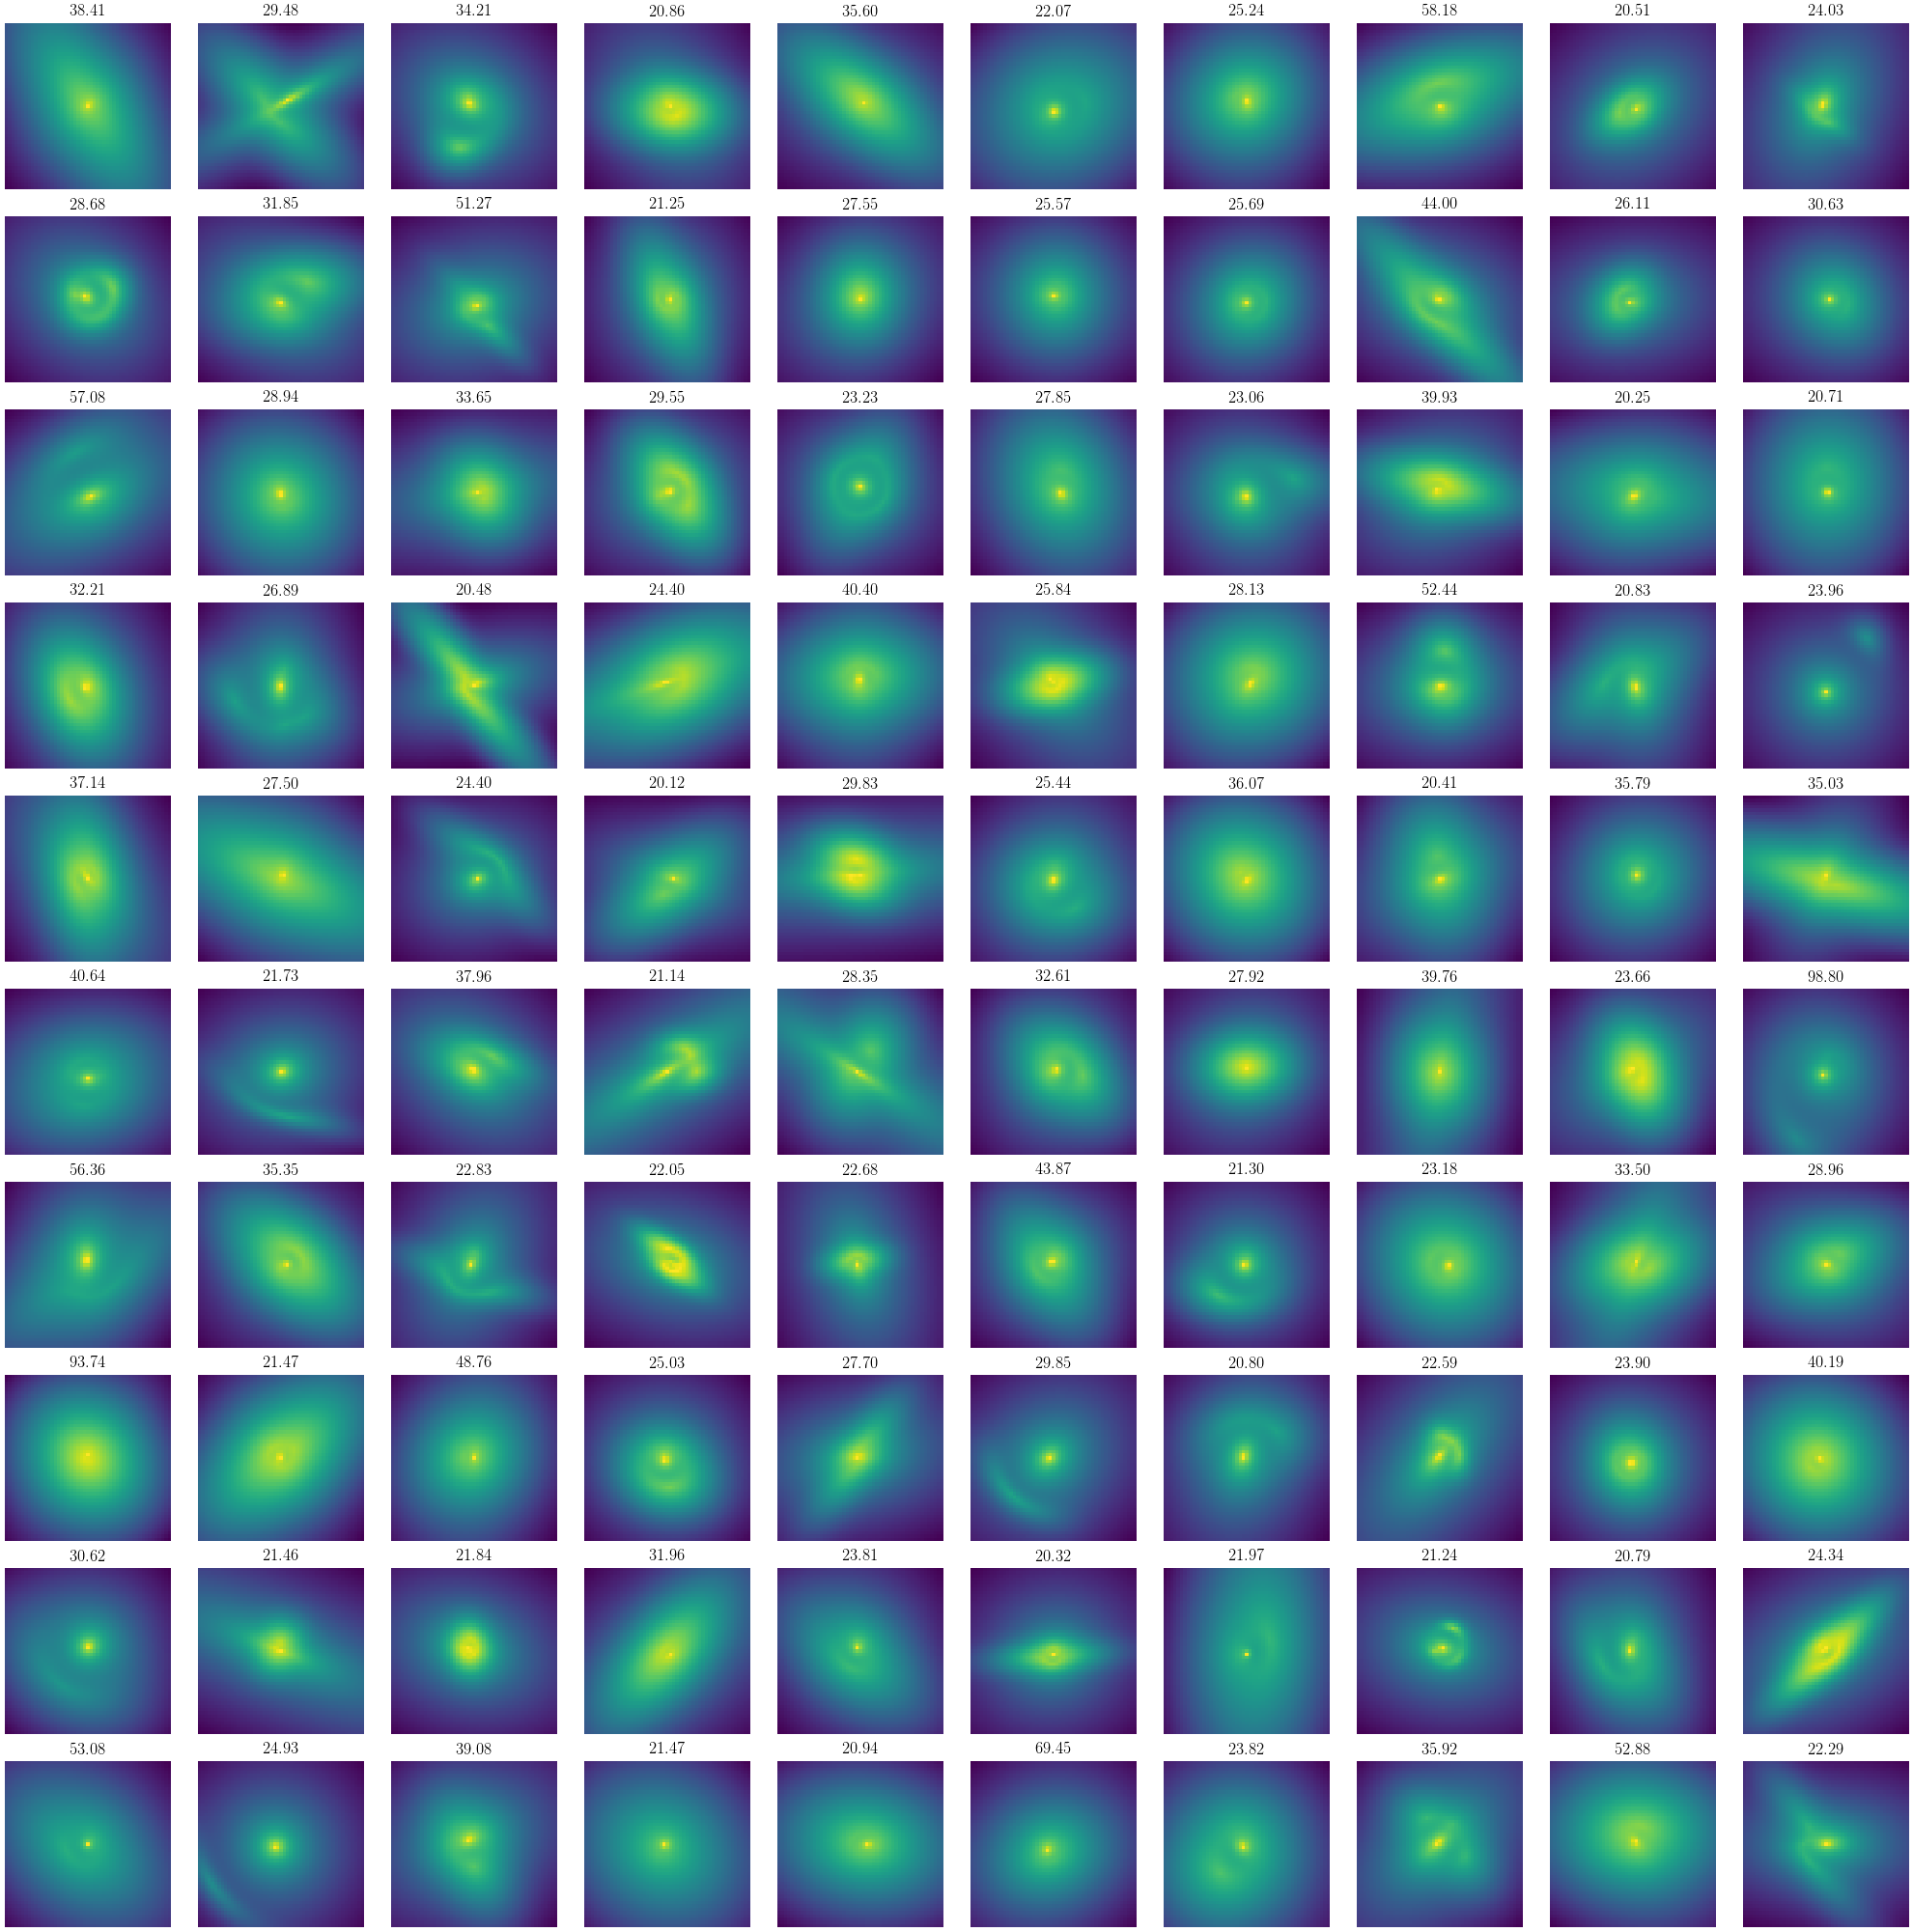

In [20]:
f, ax = plt.subplots(10, 10, figsize=(20, 20), constrained_layout=True)

i = 0
for x in range(10):
    for y in range(10):
        ax[x][y].imshow(np.log10(array_list[i]))
        ax[x][y].set_axis_off()
        ax[x][y].set_title(f'{snrs[i]:.2f}')
        i += 1

plt.savefig(os.path.join(figure_dir, 'snr_sanity_check_log10.png'))
plt.show()